<a href="https://colab.research.google.com/github/Tsulice/ML-projects/blob/main/TP8_Fairness_Cylia_ABBAD_Alice_TOURRET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import io
import matplotlib.pyplot as plt

In [ ]:
# cll dataset
datafile=""
# 0- read the file
from google.colab import files
uploaded = files.upload()

Saving cll_dataset.csv to cll_dataset.csv


In [ ]:
cll_dataset = pd.read_csv(io.BytesIO(uploaded['cll_dataset.csv']))

KeyError: ignored

In [ ]:
# a row is a sample = a patient
# column 'Treat6m' recurrence of the disease, 1 if true, 0 if false
# other columns are features = rate of several types of cells and molecules in the patient
cll_dataset.head()

,Treat6m,Naive,EMRA,CM,EM,CD11a,CXCR3,CCR5,CXCR4,CXCR5,B7-H3,BTLA,PD1,LAG-3,HLA2,CD57,CD137,CD25,CD69,PERFORIN,GzB,GzA,CD127,CD58,GAL-3,CD5,ICAM-1,CD38,CCR4,CTLA-4
0,1,0.0304,0.260,0.0150,0.2580,0.9346,0.775552,0.070052,0.339160,0.546893,0.656232,0.982216,0.256908,0.084362,0.821763,0.253181,0.060772,0.093901,0.252523,0.880222,0.781068,0.901904,0.200926,0.476314,0.818068,0.946954,0.990000,0.262730,0.270001,0.163433
1,0,0.1560,0.269,0.0387,0.0832,0.7110,0.812970,0.273710,0.375861,0.361873,0.135045,0.705116,0.652587,0.051744,0.163325,0.222673,0.036842,0.104232,0.142495,0.700707,0.425790,0.544353,0.053836,0.580217,0.469866,0.998994,0.997190,0.145660,0.321924,0.041356
2,1,0.0646,0.211,0.0363,0.2940,0.8970,0.539334,0.070597,0.162852,0.195341,0.349124,0.547168,0.602791,0.133252,0.863618,0.475020,0.466411,0.070974,0.189118,0.876636,0.780501,0.932139,0.321604,0.484588,0.762041,0.993183,0.997586,0.385564,0.249591,0.062653
3,0,0.0283,0.240,0.1180,0.1300,0.9861,0.857143,0.169069,0.199353,0.307644,0.613821,0.953178,0.738885,0.173426,0.867584,0.358332,0.073347,0.093947,0.256575,0.966187,0.864433,0.987819,0.382722,0.602925,0.645262,0.988252,0.999200,0.170346,0.400480,0.067871
4,0,0.0653,0.216,0.0949,0.2040,0.9209,0.847934,0.245060,0.182395,0.174046,0.276277,0.725921,0.490683,0.200272,0.182471,0.125216,0.099868,0.116054,0.106688,0.078826,0.609748,0.932809,0.373745,0.340299,0.102806,0.980924,0.996289,0.148594,0.156187,0.000000


In [ ]:
# -----------------------------------------------------------------------------------------
# 1- create X the features, Y the predictions
X = cll_dataset.drop('Treat6m', axis=1)
print(X.head())
Y = pd.DataFrame(cll_dataset['Treat6m'])
print(Y.head())

    Naive   EMRA      CM      EM  ...    ICAM-1      CD38      CCR4    CTLA-4
0  0.0304  0.260  0.0150  0.2580  ...  0.990000  0.262730  0.270001  0.163433
1  0.1560  0.269  0.0387  0.0832  ...  0.997190  0.145660  0.321924  0.041356
2  0.0646  0.211  0.0363  0.2940  ...  0.997586  0.385564  0.249591  0.062653
3  0.0283  0.240  0.1180  0.1300  ...  0.999200  0.170346  0.400480  0.067871
4  0.0653  0.216  0.0949  0.2040  ...  0.996289  0.148594  0.156187  0.000000

[5 rows x 29 columns]
   Treat6m
0        1
1        0
2        1
3        0
4        0


In [ ]:
# 2- Create a ft_rf function that fit a random forest on X train and Y train
# And return the random forest score on the test sample

def fit_rf(dataset_X, dataset_Y, depth):
  #First we split the sample into a train sample and a test sample:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
  
  #We define the model and its parameters
  clf = RandomForestClassifier(max_depth = depth)

  #Model fitting
  clf.fit(X_train, Y_train.values.ravel())

  # I chose to return the accuracy score, as it is a common metric to use
  return accuracy_score(Y_test, clf.predict(X_test))


In [ ]:
#Test function
fit_rf(X, Y, 2)

0.6363636363636364

In [ ]:
# 3- create a function 'repeat_experiment' that will re-shuffle the dataset and fit a classifier a hundred times
# store the score at each iteration
# return the average score on the hundred iterations

def repeat_experiment(dataset_X, dataset_Y, depth):
  
  acc_score = [0] * 100

  for i in range(100):
    acc_score[i] = fit_rf(dataset_X, dataset_Y, depth)

  return sum(acc_score)/100

In [ ]:
# 4- Is it good ? (check score averaged over a hundred experiments)
repeat_experiment(X, Y, 2)

#At first glange, a 0.74-0.76 accuracy seems alright for a first try with no model parameter tuning

0.7463636363636365

In [ ]:
# 5- Is it actually good ? 
#try to predict only vectors with 'Treat6m' = 1
#repeat_experiment(X[Y["Treat6m"] == 1], Y[Y["Treat6m"] == 1], 2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
  
#We define the model and its parameters
clf = RandomForestClassifier(max_depth = 2)

#Model fitting
clf.fit(X_train, Y_train.values.ravel())

#Prediction
print(clf.predict(X_test[Y_test["Treat6m"] == 1]))

#Even if you repeat the experiment several times,
#The random forest trained on the whole sample will always predict 0 for 
#the class 'Treat6m' = 1
#Hence, even though the accuracy is good, the model is not doing 
#good predictions. 

# You can compute per-class precision, recall, f-scores...
#precision = true positive/ (True positive + False positive)
print(precision_score(Y_test, clf.predict(X_test)))
#When repeated multiple time, the precision is always equal to 0, meaning we never 
#have a true positive. This seems logical with the fact that the model always
#wrongly predicts 0. 

#Recall 
#Recall = TruePositives / (TruePositives + FalseNegatives)
print(recall_score(Y_test, clf.predict(X_test)))
#Same observation: always equal to 0 

#f score
#f score = (2 * Precision * Recall) / (Precision + Recall)
#We cannot even compute this metrics as both precision and recall are
#equal to 0. 


[0 0]
0.0
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Treat6m
0          24
1           7
dtype: int64


Text(0.5, 1.0, 'Recurrence of the disease : frequency count')

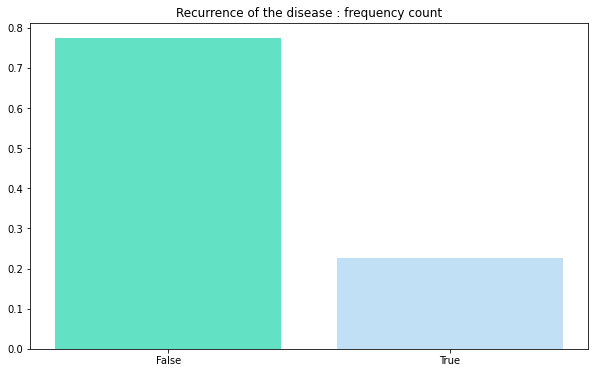

In [ ]:
# 5- Why is it actually pretty bad ?
print(Y.value_counts())
fig, ax = plt.subplots(figsize = (10,6))
bars1 = ax.bar(["False","True"], Y.value_counts()/len(Y), color = ['#63E1C4', '#C1E0F6'])
ax.set_title("Recurrence of the disease : frequency count")


#As one can see in the following graph, the dataset is imbalanced.
#Our target variable, which is when the disease reoccurs is only observed 
#for 22.6% of the patients.
#This means that our average accuracy score of around 77% is not good. 
#Indeed, as our target variable is 'rare' in occurence, it is simple for the model
#to predict 0 for all observations and get a good accuracy score.
# This comes from the formula of the accuracy score:
# (True positive + True negative)/all sample

#In our case, if our model only predicted 0 for every 31 observations,
# Our accuracy score would be: 
#(24 + 0)/31 = around 0.77
# Which is very close to our average accuracy score on 100 repetitions ! 
#Our accuracy score is just the frequency of the non-target variable.
#As our goal is to predict the target variable and our 
#model mostly predict 0, this is NOT a good method.

In [ ]:
# Amazon has recorded some data from its job interviews.
# After compiling all the data,
# they came with a pair of features called "skills" and "human fit"
# that are supposed to be sufficient to predict whether a candidate is worth interviewing.

# 0- load the data
# 0- read the file

uploaded = files.upload()
#genderdatafile = pd.read_csv(io.BytesIO(uploaded['gender_biased.csv'])).drop('Unnamed: 0', axis=1)
genderdatafile=pd.read_csv("gender_biased.csv")

Saving gender_biased.csv to gender_biased.csv


In [ ]:
# 1- Which feature should not be taken into account to discriminate candidates ?
# we call this feature "sensitive"
genderdatafile.head()

#We do not want to use the "gender" of the candidate, as it is illegal to 
#select individuals depending on their gender. 

,Unnamed: 0,skills,human_fit,gender,selected
0,0,-6.160503,-3.266742,1.0,0
1,1,1.951289,-4.117315,0.0,0
2,2,2.255315,2.801389,1.0,1
3,3,-7.440054,-3.465629,0.0,0
4,4,0.338412,-0.334471,0.0,1


Text(0.5, 1.0, 'Percentage of men and women')

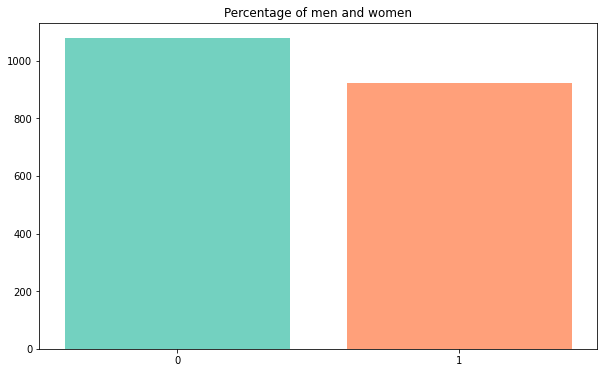

In [ ]:
#Visualisation of the gender variable
fig, ax = plt.subplots(figsize = (10,6))
bars1 = ax.bar(["0","1"], genderdatafile["gender"].value_counts(), color = ['#73D1C0', 'lightsalmon'])
ax.set_title("Percentage of men and women")


selected
1           1000
0           1000
dtype: int64


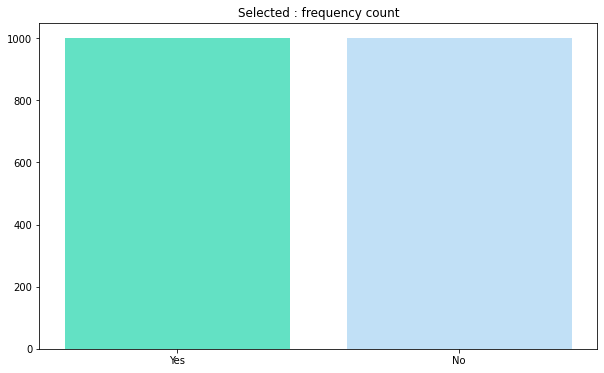

In [ ]:
# 2- Fit classifiers of your choice on the given dataset (output is "selected" column)
# do not use the "sensitive" feature !!!

#Separate into X and Y samples:
X_f = genderdatafile.drop(['selected'], axis=1)
Y_r = pd.DataFrame(genderdatafile['selected'])

#Split into train and test samples
X_train, X_test, Y_train, Y_test = train_test_split(X_f.drop('gender',axis = 1), Y_r, test_size=0.33)

#Simple Random Forest Classifier
random_f = RandomForestClassifier(max_depth = 2)

#Model fitting
random_f.fit(X_train, Y_train.values.ravel())


fig1,ax1=plt.subplots(figsize = (10,6))
bars1 = ax1.bar(["Yes","No"], Y_r.value_counts(), color = ['#63E1C4', '#C1E0F6'])
ax1.set_title('Selected : frequency count')
print(Y_r.value_counts())



#The dataset is perfectly balanced, with 50% selected and 50% not selected.
#Then it is understandable we do not have the same issue as before, as the 
#disease dataset was very unbalanced. 


accuracy 0.85
precision 0.8440366972477065
recall 0.8518518518518519
f-score 0.847926267281106


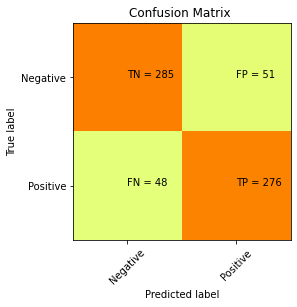

In [ ]:
# 3- Evaluate the classifiers

#On the test set:
print("accuracy",accuracy_score(Y_test, random_f.predict(X_test)))
print("precision",precision_score(Y_test, random_f.predict(X_test)))
print("recall",recall_score(Y_test, random_f.predict(X_test)))
print("f-score",f1_score(Y_test, random_f.predict(X_test)))

#As the metrics are quite stable, it is possible that we do not have the issue of the previous exercise.

#The confusion Matrix

plt.clf()
plt.imshow(confusion_matrix(Y_test, random_f.predict(X_test)), interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_matrix(Y_test, random_f.predict(X_test))[i][j]))

plt.title('Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

Text(0.5, 1.0, 'Predicted Selected : frequency count')

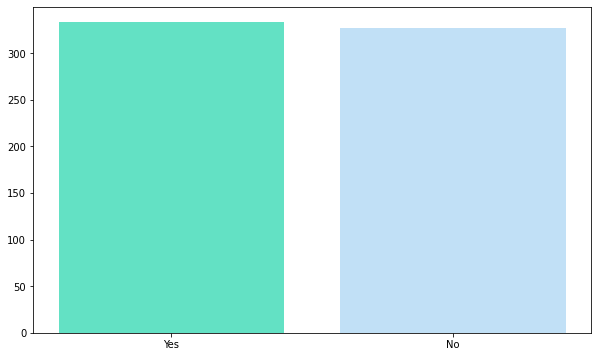

In [ ]:
#To be sure, to not have the problem of unmbalanced data, let's have a look at the sample:
predicted_selection=pd.DataFrame(random_f.predict(X_test))
fig2, ax2 = plt.subplots(figsize = (10,6))
bars1 = ax2.bar(["Yes","No"],predicted_selection[0].value_counts(), color = ['#63E1C4', '#C1E0F6'])
ax1.set_title('Predicted Selected : frequency count')

1    228
0     81
dtype: int64
accuracy for women 0.8802588996763754
precision for women 0.8991228070175439
recall for women 0.9360730593607306
f-score for women 0.9172259507829977
[[ 67  23]
 [ 14 205]]


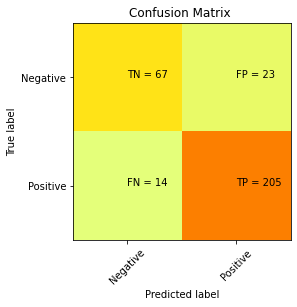

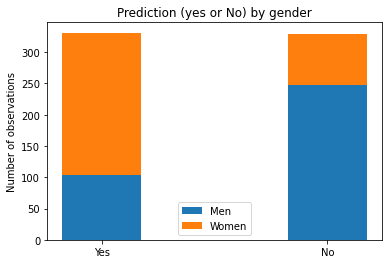

[182.0, 194.0]


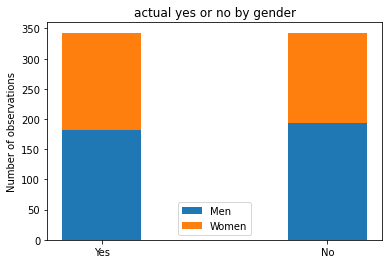

In [ ]:
# 4- What is the impact of automatic decision on the "protected group" (the one with sensitive=1)?

X_train, X_test, Y_train, Y_test = train_test_split(X_f, Y_r, test_size=0.33)
Women_pred = pd.DataFrame(random_f.predict(X_test[X_test["gender"] == 1].drop("gender",axis = 1)))

print(Women_pred.value_counts())
print("accuracy for women",accuracy_score(Y_test[X_test["gender"] == 1], Women_pred))
print("precision for women",precision_score(Y_test[X_test["gender"] == 1], Women_pred))
print("recall for women",recall_score(Y_test[X_test["gender"] == 1], Women_pred))
print("f-score for women",f1_score(Y_test[X_test["gender"] == 1], Women_pred))
print(confusion_matrix(Y_test[X_test["gender"] == 1], Women_pred))
confusion_matrix(Y_test[X_test["gender"] == 1], Women_pred)
plt.clf()
plt.imshow(confusion_matrix(Y_test[X_test["gender"] == 1], Women_pred), interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_matrix(Y_test[X_test["gender"] == 1], Women_pred)[i][j]))

plt.title('Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
#Pretty good prediction :) 

#We now check the fairness
pred = pd.DataFrame(random_f.predict(X_test.drop("gender",axis = 1)))
Pred_pos = X_test.iloc[np.where(pred==1)[0]]
Pred_neg = X_test.iloc[np.where(pred==0)[0]]


labels = ['Yes', 'No']
men_count = [np.sum(Pred_pos['gender'] == 0), np.sum(Pred_neg['gender'] == 0)]
women_count = [np.sum(Pred_pos['gender'] == 1), np.sum(Pred_neg['gender'] == 1)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_count, width, label='Men')
ax.bar(labels, women_count, width, bottom=men_count, label='Women')

ax.set_ylabel('Number of observations')
ax.set_title('Prediction (yes or No) by gender')
ax.legend()

plt.show()

#Predictions between both gender are very unbalanced: Women are more often
#predicted as "Yes". This is wrong as we now that our train sample is actually 
#fair between men and women:
fig, ax = plt.subplots()
Pred_pos = X_train.iloc[np.where(Y_test["selected"] == 1)]
Pred_neg = X_train.iloc[np.where(Y_test["selected"] == 0)]
men_count = [Pred_pos.shape[0]-np.sum(Pred_pos.gender), Pred_pos.shape[0]-np.sum(Pred_neg.gender)]
women_count = [np.sum(Pred_pos.gender), np.sum(Pred_neg.gender)]
print(men_count)
women_count
ax.bar(labels, men_count, width, label='Men')
ax.bar(labels, women_count, width, bottom=men_count, label='Women')

ax.set_ylabel('Number of observations')
ax.set_title('actual yes or no by gender')
ax.legend()


In [ ]:
#What would have happened if the gender was taken into account ? 
#Model fitting with "gender" variable
random_f.fit(X_train, Y_train.values.ravel())
print("accuracy",accuracy_score(Y_test, random_f.predict(X_test)))
print("precision",precision_score(Y_test, random_f.predict(X_test)))
print("recall",recall_score(Y_test, random_f.predict(X_test)))
print("f-score",f1_score(Y_test, random_f.predict(X_test)))
Women_pred = pd.DataFrame(random_f.predict(X_test[X_test["gender"] == 1]))
print(Women_pred.value_counts())
print("accuracy for women",accuracy_score(Y_test[X_test["gender"] == 1], Women_pred))
print("precision for women",precision_score(Y_test[X_test["gender"] == 1], Women_pred))
print("recall for women",recall_score(Y_test[X_test["gender"] == 1], Women_pred))
print("f-score for women",f1_score(Y_test[X_test["gender"] == 1], Women_pred))
print(confusion_matrix(Y_test[X_test["gender"] == 1], Women_pred))

#The quality of the prediction is actually less good, which is surprising.
#Let's look at the fairness
pred = pd.DataFrame(random_f.predict(X_test)
Pred_pos = x_testt.iloc[np.where(pred==1)[0]]
Pred_neg = x_testt.iloc[np.where(pred==0)[0]]


labels = ['Yes', 'No']
men_count = [np.sum(Pred_pos['gender'] == 0), np.sum(Pred_neg['gender'] == 0)]
women_count = [np.sum(Pred_pos['gender'] == 1), np.sum(Pred_neg['gender'] == 1)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_count, width, label='Men')
ax.bar(labels, women_count, width, bottom=men_count, label='Women')

ax.set_ylabel('Number of observations')
ax.set_title('Prediction (yes or No) by gender')
ax.legend()

plt.show()



accuracy 0.853030303030303
precision 0.8575949367088608
recall 0.8390092879256966
f-score 0.8482003129890454
1    217
0     79
dtype: int64
accuracy for women 0.8648648648648649
precision for women 0.8571428571428571
recall for women 0.9538461538461539
f-score for women 0.9029126213592232
[[ 70  31]
 [  9 186]]


In [ ]:
# 5- In sklearn, you can put a weight on samples
# Find a weighting strategy to compute a fair classification
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
# Features and output
XX = genderdatafile.drop(['selected'], axis=1)
yy = genderdatafile['selected'].to_numpy()

#Split the dataset into train and test samples
x_trainn, x_testt, y_trainn, y_testt = train_test_split(XX, yy,test_size=0.33) 

#Calculate the weights for each class
weights = class_weight.compute_class_weight('balanced',np.unique(y_trainn), y_trainn)
class_weights = {}
for i in range(2):
  class_weights[i] = weights[i]

print("weights are:",class_weights)
# Classifier and fit the model
Rfm = RandomForestClassifier(max_depth=2, class_weight=class_weights)
Rfm.fit(x_trainn.drop('gender',axis = 1), y_trainn)

weights are: {0: 0.9911242603550295, 1: 1.0090361445783131}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.9911242603550295,
                                     1: 1.0090361445783131},
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy 0.8727272727272727
Precision 0.8795180722891566
Recall 0.8690476190476191
F-score 0.8742514970059881


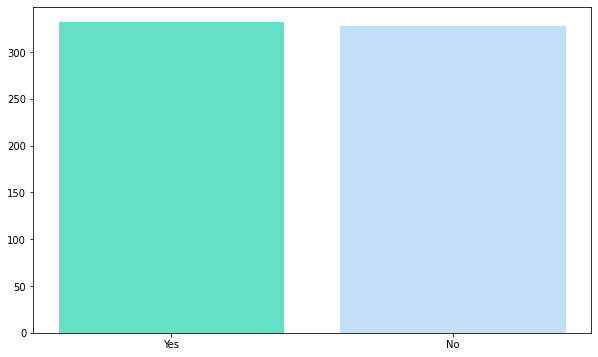

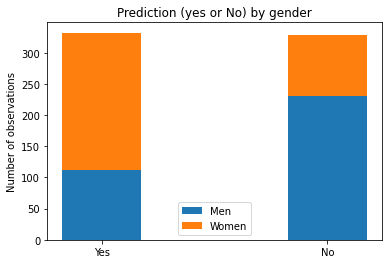

[182.0, 194.0]


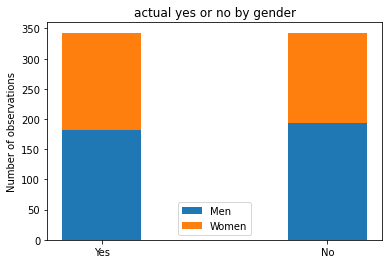

In [ ]:
# 6- Evaluate your classifier, check the trade-off between fairness and accuracy

#On the test set:
print("Accuracy",accuracy_score(y_testt, Rfm.predict(x_testt.drop('gender',axis = 1))))
print("Precision",precision_score(y_testt, Rfm.predict(x_testt.drop('gender',axis = 1))))
print("Recall",recall_score(y_testt, Rfm.predict(x_testt.drop('gender',axis = 1))))
print("F-score",f1_score(y_testt, Rfm.predict(x_testt.drop('gender',axis = 1))))

predicted_selection=pd.DataFrame(Rfm.predict(x_testt.drop('gender',axis = 1)))
fig2, ax2 = plt.subplots(figsize = (10,6))
bars1 = ax2.bar(["Yes","No"],predicted_selection[0].value_counts(), color = ['#63E1C4', '#C1E0F6'])
ax1.set_title('Predicted Selected : frequency count')
# The accuracy is reasonnable, knowing that the sample is balanced

#We now check the fairness
Pred_pos = x_testt.iloc[np.where(predicted_selection==1)[0]]
Pred_neg = x_testt.iloc[np.where(predicted_selection==0)[0]]


labels = ['Yes', 'No']
men_count = [np.sum(Pred_pos['gender'] == 0), np.sum(Pred_neg['gender'] == 0)]
women_count = [np.sum(Pred_pos['gender'] == 1), np.sum(Pred_neg['gender'] == 1)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_count, width, label='Men')
ax.bar(labels, women_count, width, bottom=men_count, label='Women')

ax.set_ylabel('Number of observations')
ax.set_title('Prediction (yes or No) by gender')
ax.legend()

plt.show()

#As we can see, the prediction is still not perfectly fair: there are more
#women predicted to be "yes" than men. 

#As the reminder, the sample is quite fair :
fig, ax = plt.subplots()
Pred_pos = X_train.iloc[np.where(Y_test["selected"] == 1)]
Pred_neg = X_train.iloc[np.where(Y_test["selected"] == 0)]
men_count = [Pred_pos.shape[0]-np.sum(Pred_pos.gender), Pred_pos.shape[0]-np.sum(Pred_neg.gender)]
women_count = [np.sum(Pred_pos.gender), np.sum(Pred_neg.gender)]
print(men_count)
women_count
ax.bar(labels, men_count, width, label='Men')
ax.bar(labels, women_count, width, bottom=men_count, label='Women')

ax.set_ylabel('Number of observations')
ax.set_title('actual yes or no by gender')
ax.legend()

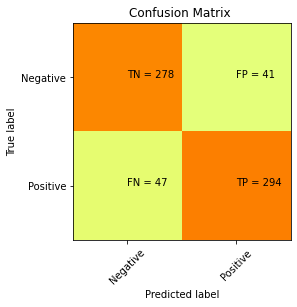

In [ ]:
#Confusion matrix
plt.clf()
plt.imshow(confusion_matrix(y_testt, Rfm.predict(x_testt)), interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_matrix(y_testt, Rfm.predict(x_testt))[i][j]))

plt.title('Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#Pretty good prediction :) 

In [ ]:
# 7- Another strategy here would be post-processing
# train the classifier without re-weighting the samples

# Features and output
X_r = genderdatafile.drop(['selected'], axis=1)
y_r = genderdatafile['selected']

#Split the dataset into train and test samples
xx_train, xx_test, yy_train, yy_test = train_test_split(X_r.drop('gender',axis=1), y_r,test_size=0.33) 

# Classifier and fit the model
Rfm_p = RandomForestClassifier(max_depth=2)
Rfm_p.fit(xx_train, yy_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#function to plot ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC',c='r')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

1    200
0    103
dtype: int64
Accuracy for women 0.8646864686468647
Precision for women 0.915
Recall for women 0.8840579710144928
F-score for women 0.8992628992628994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """


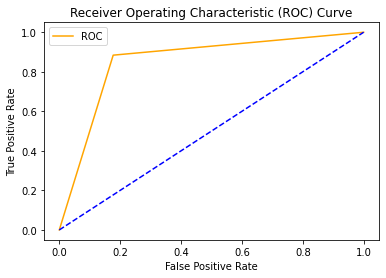

AUC: 0.85


In [ ]:
# 8- Plot ROC curve for the "protected group" (sensitive=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_r, y_r, test_size=0.33)
Women_predd = pd.DataFrame(Rfm_p.predict(X_test[X_test["gender"] == 1].drop("gender",axis = 1)))
print(Women_predd.value_counts())
print("Accuracy for women",accuracy_score(Y_test[X_test["gender"] == 1], Women_predd))
print("Precision for women",precision_score(Y_test[X_test["gender"] == 1], Women_predd))
print("Recall for women",recall_score(Y_test[X_test["gender"] == 1], Women_predd))
print("F-score for women",f1_score(Y_test[X_test["gender"] == 1], Women_predd))
fpr, tpr, thresholds = roc_curve(Y_test[X_test['gender']==1], Women_predd)
plot_roc_curve(fpr, tpr)
auc = roc_auc_score(Y_test[X_test['gender']==1], Women_predd)
print('AUC: %.2f' % auc)

0    266
1    101
dtype: int64
Accuracy for men 0.8583106267029973
Precision for men 0.8712871287128713
Recall for men 0.6929133858267716
F-score for men 0.7719298245614035
AUC: 0.82


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


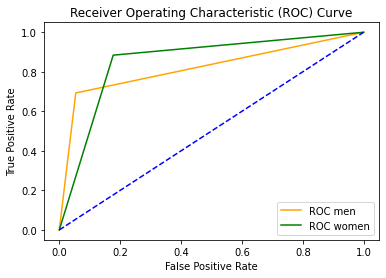

In [ ]:
# 9- On the same graph, plot the ROC curve for the "unprotected group" (sensitive=0)
X_tr, X_te, Y_tr, Y_te = train_test_split(X_r, y_r, test_size=0.33)
men_predd = pd.DataFrame(Rfm_p.predict(X_te[X_te["gender"] == 0].drop("gender",axis = 1)))
print(men_predd.value_counts())
print("Accuracy for men",accuracy_score(Y_te[X_te["gender"] == 0], men_predd))
print("Precision for men",precision_score(Y_te[X_te["gender"] == 0], men_predd))
print("Recall for men",recall_score(Y_te[X_te["gender"] == 0], men_predd))
print("F-score for men",f1_score(Y_te[X_te["gender"] == 0], men_predd))
fpr1, tpr1, thresholds1 = roc_curve(Y_te[X_te['gender']==0], men_predd)
#plot_roc_curve(fpr1, tpr1)
auc1 = roc_auc_score(Y_te[X_te['gender']==0], men_predd)
print('AUC: %.2f' % auc1)



plt.plot(fpr1, tpr1, color='orange', label='ROC men',c='r')
plt.plot(fpr, tpr, color='green', label='ROC women',c='r')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


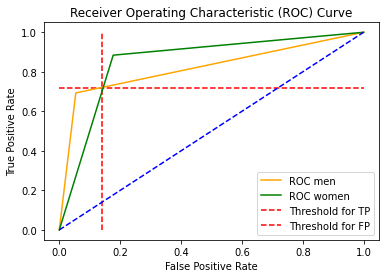

In [ ]:
# 10- Find a fair thresholding rule on the prediction of your classifier
plt.plot(fpr1, tpr1, color='orange', label='ROC men',c='r')
plt.plot(fpr, tpr, color='green', label='ROC women',c='r')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.hlines(0.72, 0, 1, colors='red', linestyles='dashed', label='Threshold for TP')
plt.vlines(0.14, 0, 1, colors='red', linestyles='dashed', label='Threshold for FP')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#As the variable to predict is equal to 1 in 50% of the case in our train sample, 
#the ideal would be to choose a true positive rate threshold at 50%. 
#However, at the threshold of 50%, the prediction is not fair:
#Indeed, men have a  false positive rate of around 30 % and women have 
#a false positive rate of around 10% (approximately).
#To have a fair prediction, we could choose the true positive rate where yellow
#and green curve meet.
#This would mean men and women would have the same false positive rate and 
#True positive rate. Hence there is no difference in prediction between 
#both group.
#This threshold is at 72% of true positive rate (meaning 14% of False positive rate).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  


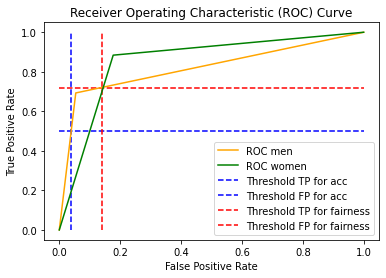

In [ ]:
# 11- Evaluate trade-off between accuracy and fairness
#A model with perfect accuracy would require a true positive rate of 50% to be true to our data
#If we look at the graph, going to 0.5 of true positive rate to 0.76 entails a rise 
#in the False positive raise of 0.14 - 0.4 = 10% ! Meaning there will be less true positives.
# Then, Accuracy = (tp + tn)/allsample will also go down by a bit less than 10%.
#So to get a perfectly fair prediction, we do have to sacrifice acccuracy. 


plt.plot(fpr1, tpr1, color='orange', label='ROC men',c='r')
plt.plot(fpr, tpr, color='green', label='ROC women',c='r')
plt.hlines(0.5, 0, 1, colors='blue', linestyles='dashed', label='Threshold TP for acc')
plt.vlines(0.04, 0, 1, colors='blue', linestyles='dashed', label='Threshold FP for acc')
plt.hlines(0.72, 0, 1, colors='red', linestyles='dashed', label='Threshold TP for fairness')
plt.vlines(0.14, 0, 1, colors='red', linestyles='dashed', label='Threshold FP for fairness')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()